In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as utils
import matplotlib.pyplot as plt
import numpy as np 
from tqdm import tqdm
import cv2
from torch.utils.data import TensorDataset, DataLoader


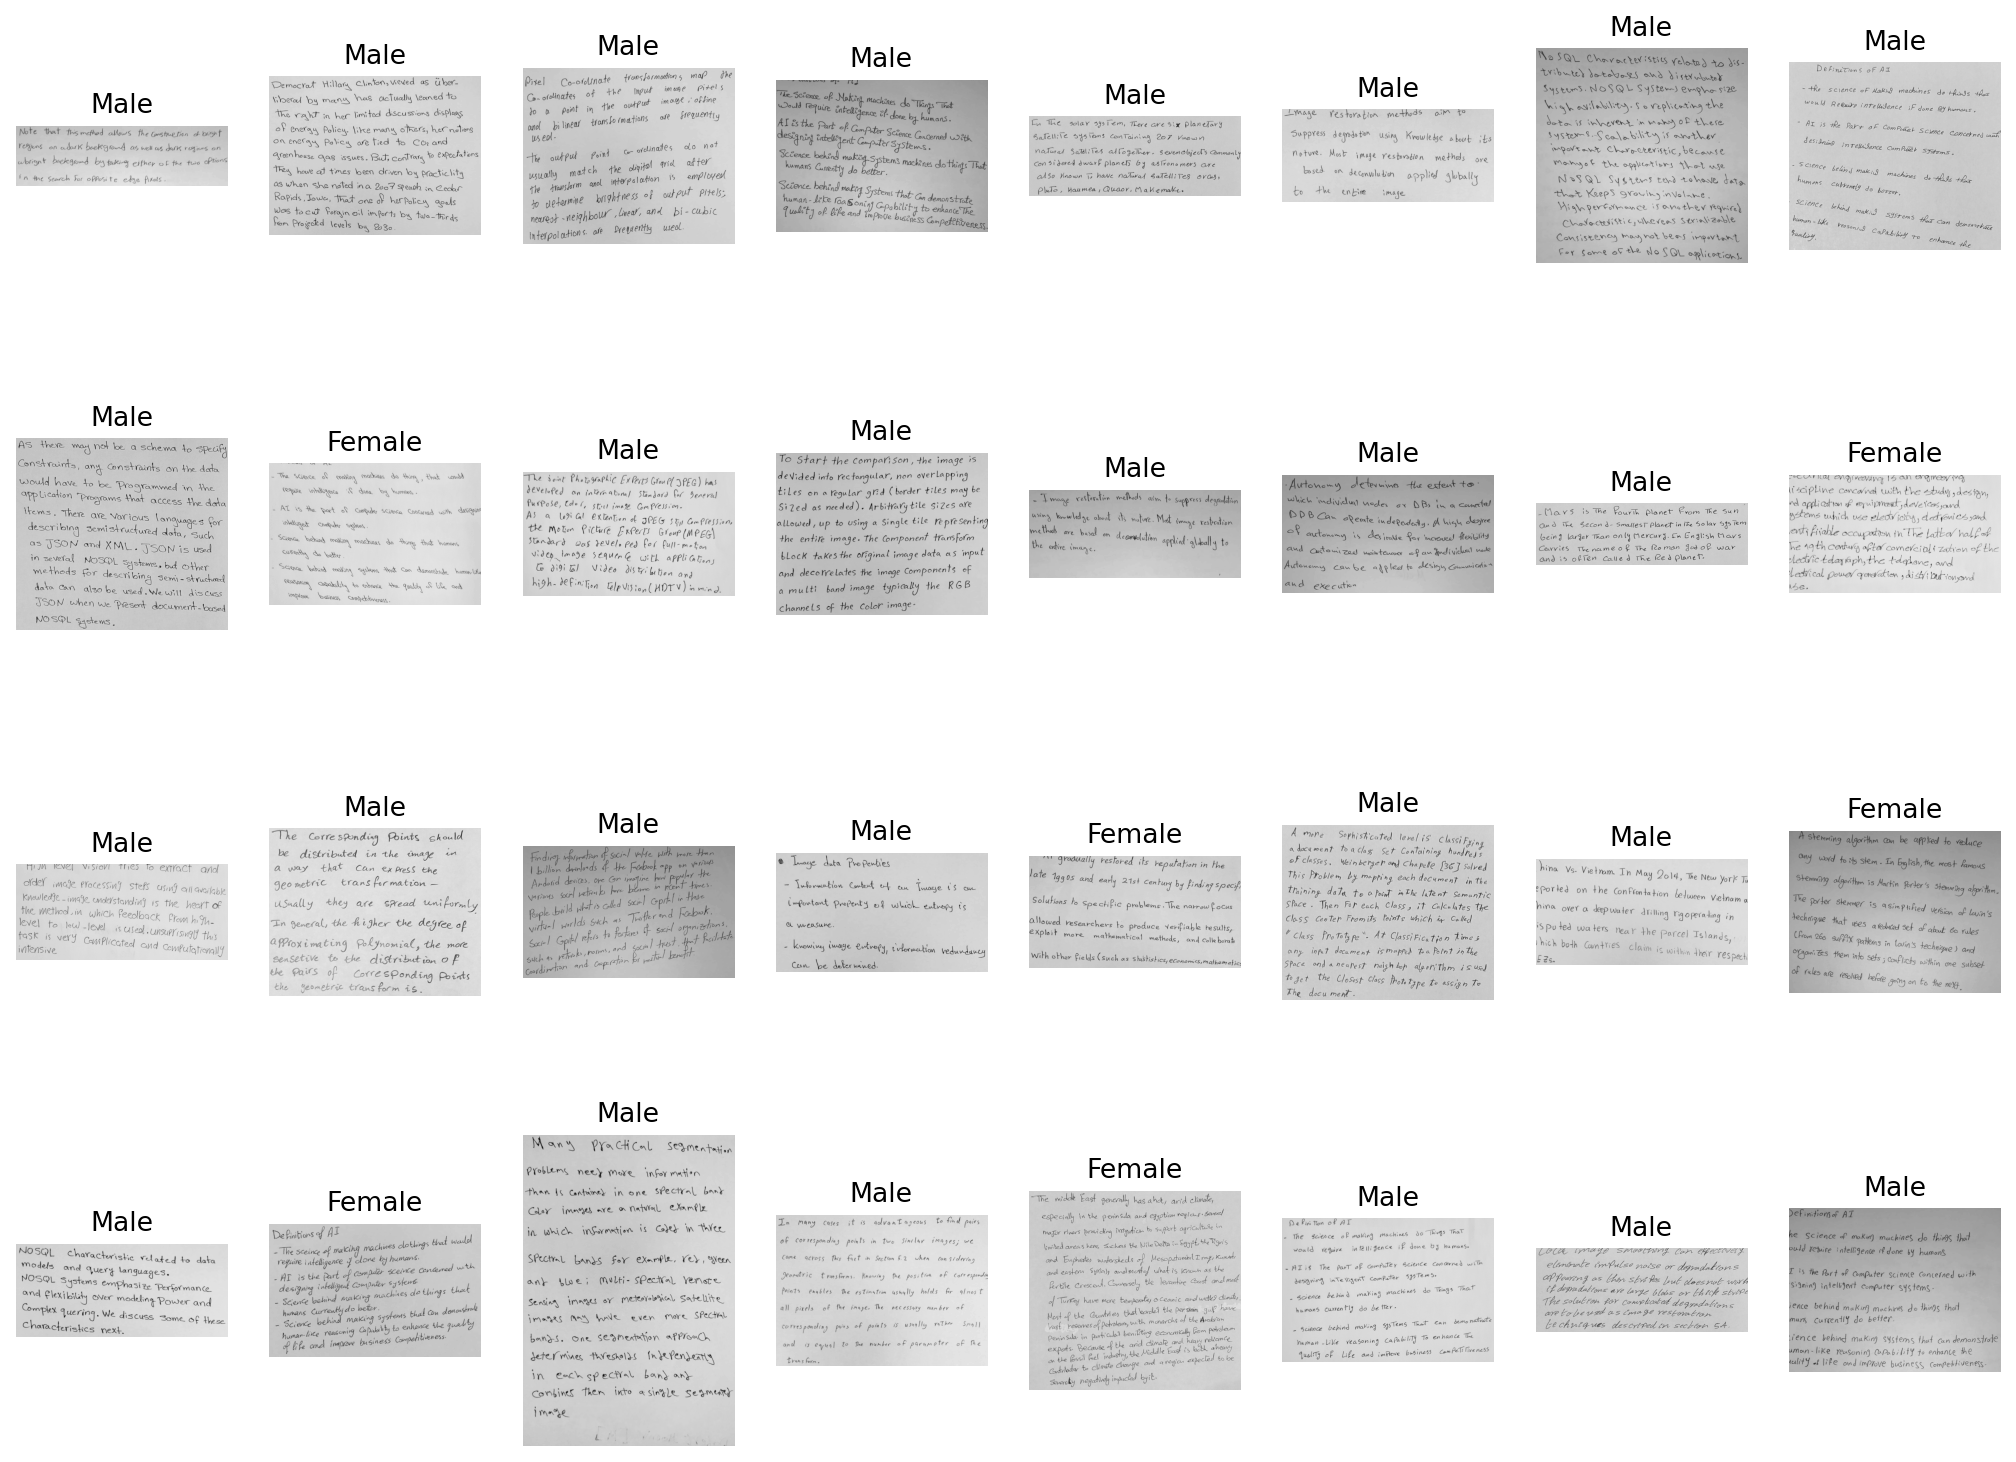

 length of training set is 271
 length of validation set is 91


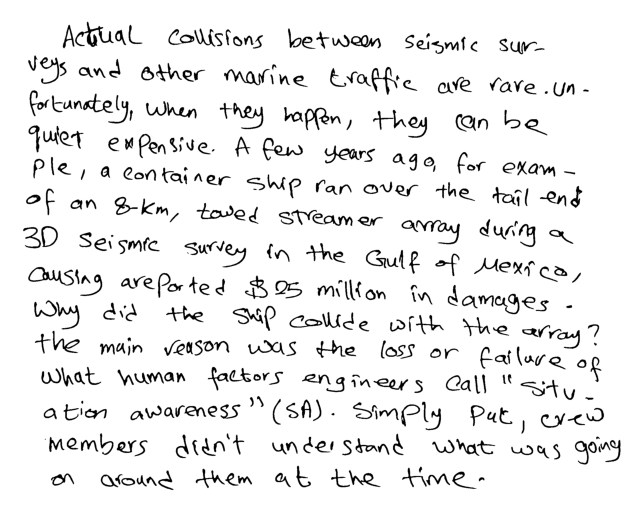

 At 0.0738007380073800756

/var/folders/nq/f_nplzp52qx_hrrhyg44xf4c0000gn/T/ipykernel_14329/2011990972.py:33: RuntimeWarning: divide by zero encountered in log
  coeffs = np.polyfit(np.log(box_sizes), np.log(partial_box_counts), 1)


 At 0.99630996309963197

KeyboardInterrupt: 

KeyboardInterrupt: 

In [3]:
%run ../Features/FindFractalFeatures.ipynb
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_size = x_train.shape[1]
output_size = 2
dataset_length = x_train.shape[0]
# Hyper-parameters
#img_size = 400
N, H, K = input_size, 200, output_size      # No. of input features (input layer size), hidden layer size, No. of classes (output layer size)
num_epochs, batch_size = 10, 64
learning_rate = 0.001

print("Hidden Layer Size: ", H)


In [62]:
def prepare_dataset(x_train, y_train, x_test, y_test):
    x_train = torch.Tensor(x_train) # transform to torch tensor
    y_train = torch.Tensor(y_train) # transform to torch tensor
    y_train = y_train.type(torch.LongTensor)
    x_test = torch.Tensor(x_test) # transform to torch tensor
    y_test = torch.Tensor(y_test) # transform to torch tensor
    y_test = y_test.type(torch.LongTensor)

    print(x_train.shape)
    print(x_test.shape)
    train_dataset = TensorDataset(x_train, y_train)
    test_dataset = TensorDataset(x_test, y_test)

    # Data loader: now they are converted to batches of [batch_size, 1, P, P]
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


    return train_loader, test_loader

train_loader, test_loader = prepare_dataset(x_train, y_train, x_test, y_test)
    

torch.Size([271, 2])
torch.Size([91, 2])


In [63]:
# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, N, H, K):                    # Give the model the no. of neurons in the input, hidden and output layers
        super(NeuralNet, self).__init__()

        self.netLayers= nn.Sequential(
        nn.Linear(N, H), nn.ReLU(),                 # First hidden Layer             
        nn.Linear(H, K)                             # Output Layer
        )

        self.N = N
        # Loss and optimizer
        self.criterion = nn.CrossEntropyLoss()      # Loss function
        self.optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)  # To minimize loss
       
    def forward(self, x):
        logits = self.netLayers(x)
        return logits

    def train(self, num_epochs, train_loader):
        for epoch in range(num_epochs):
            for  (features, labels) in tqdm(train_loader):  #each batch is a tuple of features and their corresponding labels.
                
                features = features.to(device)        # from [batch_size, 1, P, P] to [batch_size, P**2]
                labels = labels.to(device)                      # [batch_size] : Dataset labels of current batch
                
                # Forward pass
                logits = self(features)                          # Propagate the batch: gives output [batch_size, K] 
                loss = self.criterion(logits, labels)          # Calculate the loss (uses Softmak on the outputs along the way)
                
                # Backward Pass
                self.optimizer.zero_grad()                     # Clear the gradients for all network parameters (e.g. due to a previous batch)
                loss.backward()                                # Accumulate all the gradients due to the current batch
                self.optimizer.step()                          # Update the network's weights and biases
                
        
    
    def test(self, train_loader):
        with torch.no_grad():
            n_correct = 0
            n_correct_rand = 0
            for test_features, test_labels in train_loader:
                test_features = test_features.to(device)     # Flattening the image first
                test_labels = test_labels.to(device)
                logits = self(test_features)                                 # Propagate the test batch
                predicted = logits.argmax(1)                    #the highest logit is also the highest softmax probability. This has shape (batch_size,)
                n_correct += (predicted == test_labels).sum().item()

                random_guess = torch.from_numpy(np.random.randint(0,2,len(predicted)))
                n_correct_rand += (random_guess == test_labels).sum().item()

            acc = 100.0 * n_correct / (len(train_loader) * batch_size)
            acc_rand = 100.0 * n_correct_rand / (len(train_loader) * batch_size)
            return acc, acc_rand
    


In [64]:
def predict_gender(handwriting, saved=False):
    model = NeuralNet(N, H, K).to(device)      #so it's done on the GPU if available.

    # Load or Train the model
    if saved:
        model.load_state_dict(torch.load('./Intelligence/GenderIntelligence.pth'))
    else:
        train_loader, test_loader = prepare_dataset(x_train, y_train, x_test, y_test) 
        print("Training Starts!")                           # Prepare dataset
        model.train(num_epochs, train_loader)                                    # Train the model
        acc, acc_rand = model.test(train_loader)  
        if acc < 70:
            print(f"Your model is underfitting. It's unable to make good use of the features. The Training accuracy is: {acc}")
        acc, acc_rand = model.test(test_loader)                            # Test the model
        print(f"and this is the testing accuracy for the model {acc} compared to {acc_rand} for random guessing")
        
        torch.save(model.state_dict(), './Intelligence/GenderIntelligence.pth')

    if(handwriting):
       pass
    return ''


In [65]:
predict_gender('');

torch.Size([271, 2])
torch.Size([91, 2])
Training Starts!


100%|██████████| 5/5 [00:00<00:00, 811.06it/s]

Your model is underfitting. It's unable to make good use of the features. The Training accuracy is: 56.5625
and this is the testing accuracy for the model 39.0625 compared to 39.0625 for random guessing
